In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 1. On recharge votre "Carte" (le fichier Excel)
# Assurez-vous que le chemin est bon
excel_path = r"dataset_metadata.xlsx"
df = pd.read_excel(excel_path)

# Petit check de sécurité : on vérifie que les chemins sont bien des chaînes de caractères
df['path'] = df['path'].astype(str)
df['label'] = df['label'].astype(str)

In [3]:
from sklearn.model_selection import train_test_split

# 1. On isole d'abord le jeu de TEST (15%)
# Le reste (85%) servira pour Train + Val
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.15, 
    stratify=df['label'], # Important : garde la même proportion de photos/autres
    random_state=42
)

# 2. On recoupe le reste pour obtenir TRAIN et VALIDATION
# On veut que Val fasse environ 15% du total initial, donc ~17.6% du morceau restant
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.176, 
    stratify=train_val_df['label'],
    random_state=42
)

print(f"Images d'Entraînement : {len(train_df)}")
print(f"Images de Validation  : {len(val_df)}")
print(f"Images de Test        : {len(test_df)}")

Images d'Entraînement : 28994
Images de Validation  : 6194
Images de Test        : 6210


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# On crée un générateur de base (avec normalisation)
# Note : On n'utilise plus 'validation_split' ici car on a déjà découpé nos DataFrames
datagen = ImageDataGenerator(rescale=1./255)

# 1. Générateur TRAIN
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True  # OUI, on mélange pour l'apprentissage
)

# 2. Générateur VALIDATION
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False # Non, pas nécessaire
)

# 3. Générateur TEST (Celui qui manquait !)
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=1, # Souvent 1 pour tester image par image
    class_mode='binary',
    shuffle=False # IMPÉRATIF : Ne pas mélanger pour comparer les prédictions aux vraies étiquettes
)

Found 28994 validated image filenames belonging to 2 classes.
Found 6194 validated image filenames belonging to 2 classes.
Found 6210 validated image filenames belonging to 2 classes.


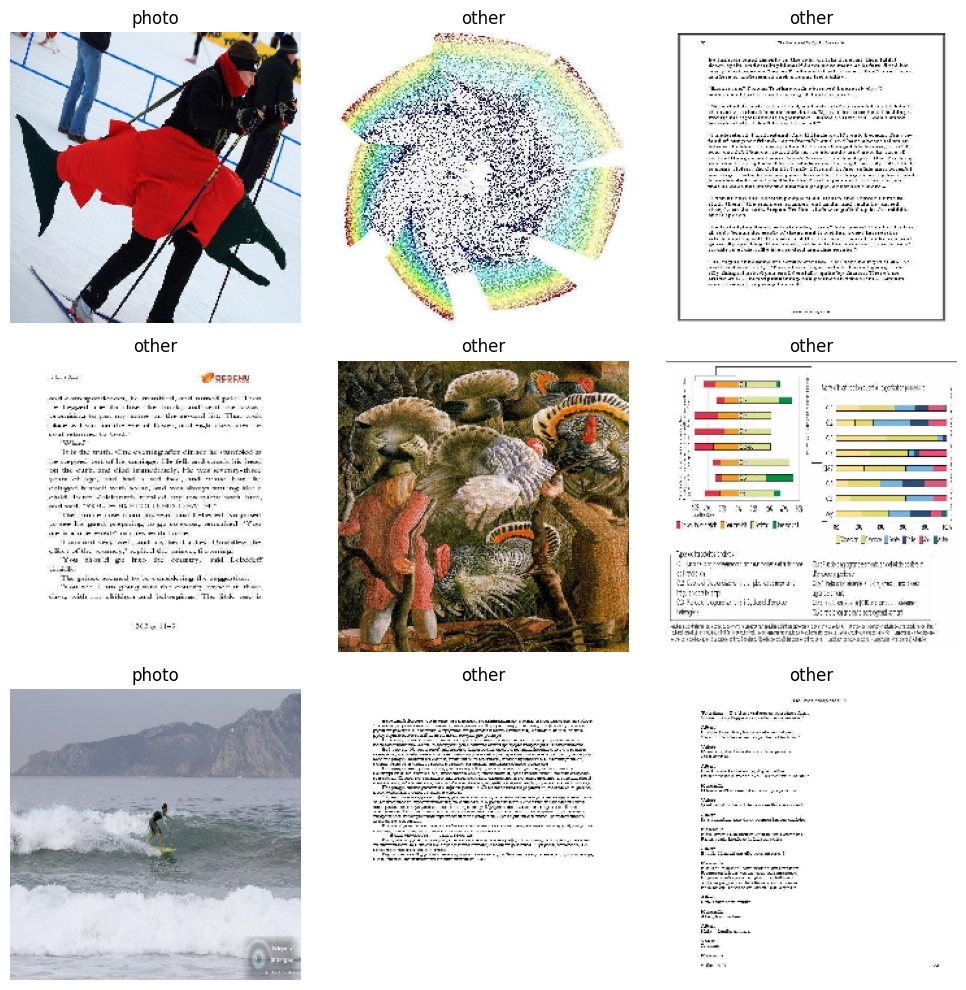

In [6]:
import matplotlib.pyplot as plt

def visualize_training_batch(generator):
    # 1. Get the next batch of data from the generator
    # It returns a tuple: (images, labels)
    images, labels = next(generator)
    
    # 2. Get the class names (e.g., {'other': 0, 'photo': 1})
    # We invert it to get {0: 'other', 1: 'photo'} for display
    class_indices = generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}

    # 3. Setup the 3x3 grid
    plt.figure(figsize=(10, 10))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        # Since they are floats between 0 and 1, matplotlib displays them correctly
        plt.imshow(images[i])
        
        # Get the label for this specific image
        # labels[i] is a float (0.0 or 1.0), so we cast to int
        class_label = label_map[int(labels[i])]
        
        plt.title(class_label)
        plt.axis("off") # Hide the x/y axis numbers
        
    plt.tight_layout()
    plt.show()

# --- Run the function ---
visualize_training_batch(train_generator)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(224, 224, 3)):
    """
    Builds a simple Binary Classification CNN.
    
    Args:
        input_shape (tuple): The shape of the input image (Height, Width, Channels).
    
    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    model = models.Sequential()

    # --- Block 1 ---
    # 32 filters look for basic features (edges, corners)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2))) 

    # --- Block 2 ---
    # 64 filters look for more complex shapes (circles, squares)
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # --- Block 3 ---
    # 128 filters look for high-level concepts (text patterns, object parts)
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # --- Classifier Head ---
    model.add(layers.Flatten())  # Convert 3D matrix to 1D vector
    
    # Dense layer to interpret the features
    model.add(layers.Dense(128, activation='relu'))
    # Dropout helps prevent overfitting (randomly ignores 50% of neurons during training)
    model.add(layers.Dropout(0.5)) 
    
    # Output Layer
    # 1 neuron with 'sigmoid' activation is standard for Binary Classification
    # Output approaches 0 (Class 0) or 1 (Class 1)
    model.add(layers.Dense(1, activation='sigmoid'))

    # --- Compile the Model ---
    model.compile(
        optimizer='adam',             # The standard, efficient optimizer
        loss='binary_crossentropy',   # The standard loss for Binary problems
        metrics=['accuracy']          # We want to track accuracy
    )
    
    return model

# --- Instantiate the Model ---
# Create the model
model = create_cnn_model()

# Print a summary to check parameter count
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Starting training...
Epoch 1/20
906/906 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.8125
Epoch 1: val_accuracy improved from -inf to 0.85946, saving model to touNum_classifier_best.keras
906/906 [==============================] - 293s 310ms/step - loss: 0.3535 - accuracy: 0.8125 - val_loss: 0.2920 - val_accuracy: 0.8595
Epoch 2/20
906/906 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.8751
Epoch 2: val_accuracy improved from 0.85946 to 0.88633, saving model to touNum_classifier_best.keras
906/906 [==============================] - 146s 161ms/step - loss: 0.2758 - accuracy: 0.8751 - val_loss: 0.2463 - val_accuracy: 0.8863
Epoch 3/20
906/906 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9017
Epoch 3: val_accuracy improved from 0.88633 to 0.90738, saving model to touNum_classifier_best.keras
906/906 [==============================] - 195s 215ms/step - loss: 0.2279 - accuracy: 0.9017 - val_loss: 0.2203 - val_acc

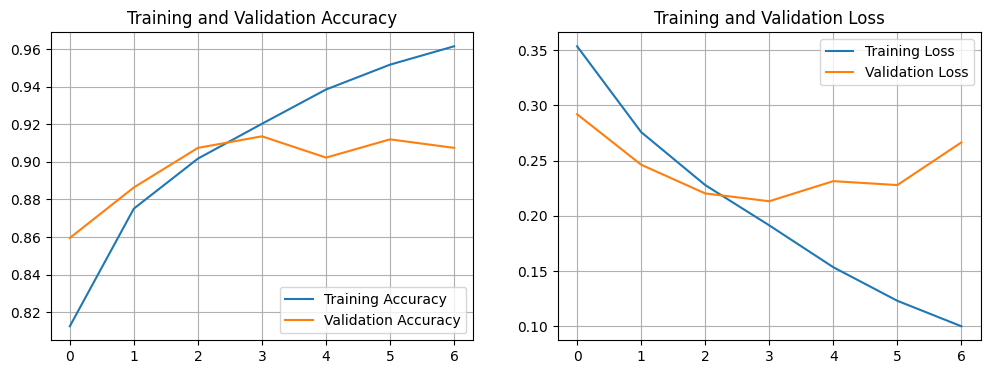

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# --- 1. Define Callbacks ---
# Save the best model to a file
checkpoint = ModelCheckpoint(
    'touNum_classifier_best.keras', # Filename
    monitor='val_accuracy',         # Watch the validation accuracy
    save_best_only=True,            # Only overwrite if accuracy improves
    mode='max',                     # We want accuracy to be maximum
    verbose=1                       # Print a message when saving
)

# Stop if we don't improve for 3 epochs in a row (patience)
early_stop = EarlyStopping(
    monitor='val_loss',             # Watch the validation loss (error rate)
    patience=3,                     # Wait 3 epochs before giving up
    restore_best_weights=True       # Go back to the best version when stopping
)

# --- 2. Train the Model ---
print("Starting training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,                      
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stop]
    # Removed 'workers=4' to fix the TypeError
)

print("Training finished.")
# --- 3. Visualize Results (Accuracy per Epoch) ---
# This creates the graph to put in your report
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.show()

In [9]:
# 1. Charger la meilleure version sauvegardée (par sécurité)
from tensorflow.keras.models import load_model
best_model = load_model('touNum_classifier_best.keras')

# 2. Évaluer sur le Test Set
print("Évaluation sur le jeu de Test...")
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f"\n--- RÉSULTATS FINAUX ---")
print(f"Précision (Accuracy) : {test_accuracy*100:.2f}%")
print(f"Perte (Loss) : {test_loss:.4f}")

Évaluation sur le jeu de Test...
6210/6210 [==============================] - 80s 13ms/step - loss: 0.2128 - accuracy: 0.9161

--- RÉSULTATS FINAUX ---
Précision (Accuracy) : 91.61%
Perte (Loss) : 0.2128
